# advsteg

In [49]:
from pathlib import Path

import torch
from PIL import Image
from torchvision import transforms

from advsteg import AliceEncoder, BobDecoder


### Parameters and weights

In [50]:
msg_length = 100
image_size = 109
output_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [51]:
# weights for the 100 epoch 10% dataset model
# weights = torch.load("../runs/generous-darkness-28/advsteg_weights.pt")


In [52]:
# weights for the 500 epochs whole dataset model
weights = torch.load("../runs/rose-butterfly-23/advsteg_weights.pt")


### Initialize model

In [53]:
encoder = AliceEncoder(msg_length, image_size, output_size).to(device)
decoder = BobDecoder(msg_length, output_size).to(device)

# Load model from weights
encoder.load_state_dict(weights["anet"])
decoder.load_state_dict(weights["bnet"])


<All keys matched successfully>

### Load a batch of images

In [54]:
def preprocess(image):
    transform = transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    return transform(image)


In [55]:
# Load 10 images from ../data/celeba/img_align_celeba/
images = []
path = "../data/celeba/img_align_celeba/"

files = Path(path).glob("*")
for _ in range(10):
    image = next(files)
    image = Image.open(image)
    images.append(image)


### Visualize cover images

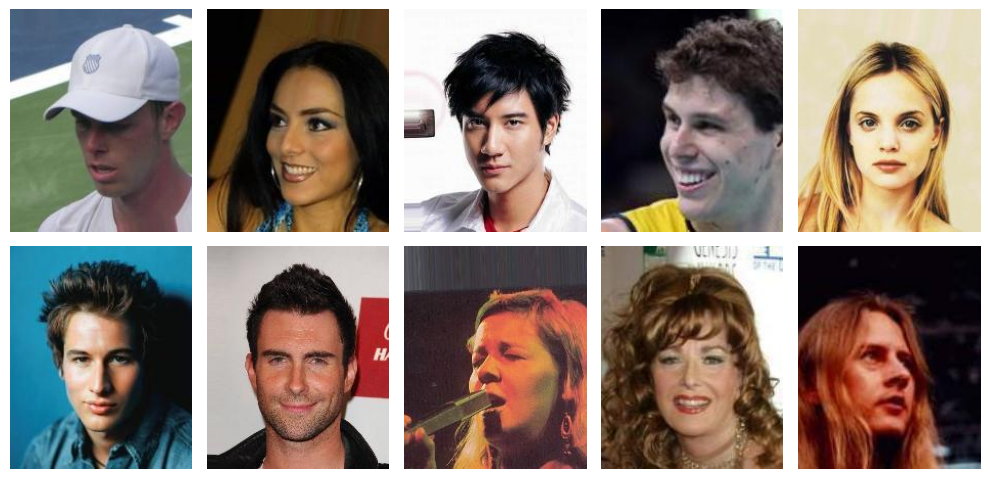

In [56]:
import matplotlib.pyplot as plt

# Plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, image in enumerate(images):
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()


### Start encoding

In [57]:
# Preprocess images and stack them into a batch
images = [preprocess(image) for image in images]
images = torch.stack(images)
images = images.to(device)

# Generate messages
messages = torch.randint(0, 2, size=(images.shape[0], msg_length))
messages = (messages * 2 - 1) / 2
messages = messages.to(device)

# Generate stego images with Alice
stego_images = encoder(images, messages)

# Decode messages with Bob
decoded_messages = decoder(stego_images)


### Visualize encoded images

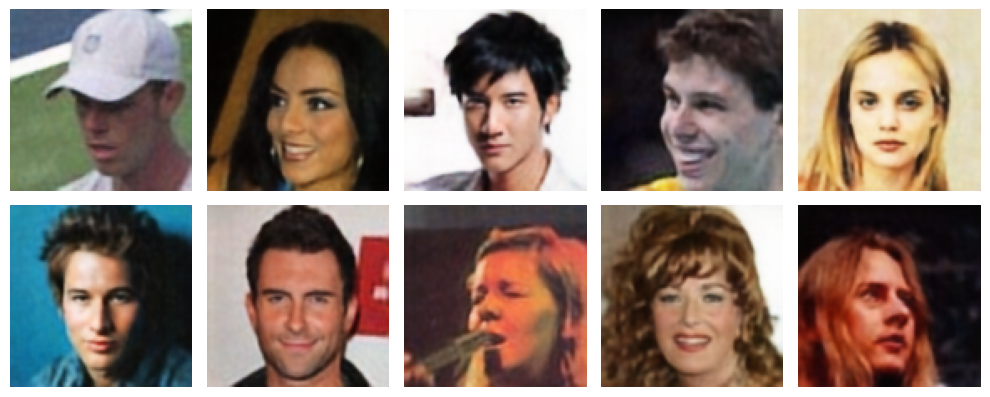

In [58]:
# Plot the stego images (need to be denormalized)
fig, axs = plt.subplots(2, 5, figsize=(10, 4.2))
for i, image in enumerate(stego_images):
    image = image.cpu().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = (image + 1) / 2
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

### Check decoding accuracy

In [59]:
def logits_to_bits(decoded):
    decoded = decoded.detach().cpu().numpy()
    decoded = (decoded * 2 + 1) / 2
    return decoded.round().astype(int)


secret_msg = logits_to_bits(messages[0])
decoded_secret = logits_to_bits(decoded_messages[0])
print("Secret:", "".join([str(s) for s in secret_msg]))
print("Decoded:", "".join([str(d) for d in decoded_secret]))


Secret: 0100100001011110100010111000100111100000000110111001011001101110110010001001111111000100100001100011
Decoded: 0100100001011110100010111000100111100000000110111001011001101110110010001001111111000100100001100011


In [60]:
# Number of correctly decoded bits
accuracy = (logits_to_bits(messages) == logits_to_bits(decoded_messages)).mean()
print(f"Decoding accuracy: {accuracy * 100:.2f}%")


Decoding accuracy: 100.00%
